In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from imp import load_source

aps = load_source(  'aggregate_player_stats', '../exploration/aggregate_player_stats.py' )
nps = load_source(  'normalize_player_stats', '../normalization/normalize_player_stats.py' )

%matplotlib inline

plt.rcParams['figure.figsize'] = (14,10)
plt.style.use('dark_background')

In [2]:
position = 'QB'
n_weeks  = 4
end_year = 2017

my_df = aps.generate_player_features( end_year, position, n_weeks=n_weeks )

In [3]:
target_variables = [
                    'log_rush_yds_25',
#                    'rush_tds',
                    'log_pass_yds_1',
#                    'pass_tds',
                    'turnovers',
#
                    'tds'
                   ]

meta_info     = [
                 'player_id',
                 'team',
                 'week',
                 'year',
                 'team_home_frac_prev_4',
#                 'few_reg_weeks'
                ]


player_scales = [
                 'pass_complete_prev_4',
                 'pass_incomplete_prev_4',
                 'pass_air_yds_prev_4',
                 'pass_air_yds_max_prev_4',
                 'pass_yds_prev_4',
                 'pass_att_prev_4'
                ]

player_norms = [
                'pass_int_prev_4',
                'pass_tds_prev_4',
                'rush_yds_prev_4',
                'rush_tds_prev_4',
                'rush_att_prev_4'
                ]

fumb_features    = [
                    'fumb_lost_prev_4', 
                    'fumb_rec_prev_4', 
                    'fumb_forced_prev_4', 
                    'fumb_nforced_prev_4'
                   ]

team_features    = [
                    'team_tds_prev_4',
                    'team_fg_made_prev_4',
                    'team_kickoffs_prev_4',
                    'team_punts_prev_4'
                   ]


opp_features     = [
                    'opp_avg_tds_prev_4', 
                    'opp_avg_fg_made_prev_4',
                    'opp_avg_rush_yds_prev_4', 
                    'opp_avg_pass_yds_prev_4',
                    'opp_avg_def_tkl_loss_prev_4', 
                    'opp_avg_def_sack_prev_4', 
                    'opp_avg_def_pass_def_prev_4'
                   ]

In [4]:
# Make turnovers a feature
temp_df = my_df.copy()

temp_df['turnovers'] = temp_df['pass_int']+temp_df['fumb_lost']
temp_df = temp_df.drop( ['pass_int','fumb_lost'], axis=1 )

# Not calc the frac of home games
temp_df['team_home_frac_prev_4'] = temp_df['team_home_flag_prev_4'] / \
                                  (temp_df['team_home_flag_prev_4'] +
                                   temp_df['team_away_flag_prev_4'] +
                                   0.                               )
temp_df = temp_df.drop( ['team_home_flag_prev_4','team_away_flag_prev_4'], axis=1 )


#
# Combine touchdowns
temp_df['tds'] = temp_df['pass_tds'] + temp_df['rush_tds']
temp_df = temp_df.drop( ['pass_tds','rush_tds'], axis=1 )

#
# Do logs of rush and passing yds
temp_df['log_pass_yds_1' ] = np.log10( temp_df['pass_yds']+ 1. ).fillna(0)
temp_df['log_rush_yds_25'] = np.log10( temp_df['rush_yds']+25. )
temp_df = temp_df.drop( ['pass_yds','rush_yds'], axis=1 )

#
# Only take regular seasons
temp_df = temp_df.loc[ temp_df['few_reg_weeks']==0 ]
temp_df = temp_df.drop( 'few_reg_weeks', axis=1 )

/home/sean/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in log10


In [5]:
# Let's start by training
#  on all data pre-2016
# Apparently 2017 preseason data missing from the db
my_train_data = temp_df.loc[ my_df['year']< 2017 ].reset_index().drop( 'index', axis=1 )
my_test_data  = temp_df.loc[ my_df['year']>=2017 ].reset_index().drop( 'index', axis=1 )

In [6]:
# Dictionary to save normalization data in
norm_dict = {}

# Do seperately
df_list = [
            my_train_data,
            my_test_data
          ]

out_df_list = []

# By looping over these,
#  will set data using train data,
#  then apply stuff to test data
# Adds then uses values from the dict
for frame in df_list:
    
    
    # Grab some normalized fumble features
    fumb_junk = nps.fumb_normalization( 
                                        frame, 
                                        fumb_features,
                                        norm_dict
                                      )
    
    # Some normalized team features
    team_junk = nps.team_normalization( 
                                        frame,
                                        team_features,
                                        norm_dict,
                                        'team_fg_miss_prev_4'
                                      )
    
    # Some opposing team features
    opp_junk = nps.opp_normalization( 
                                      frame,
                                      opp_features,
                                      norm_dict
                                    )
    
    # The QB features
    qb_junk = nps.qb_normalization(
                                    frame,
                                    player_norms,
                                    player_scales,
                                    norm_dict
                                  )
    
    # What we will output
    new_frame = frame[meta_info+target_variables]

    # Combine all the stuff into 1 frame
    out_df_list.append(
                        pd.concat( [
                                    new_frame,
                                    qb_junk,
                                    fumb_junk,
                                    team_junk,
                                    opp_junk
                                   ], axis=1).copy()
                      )
    
    
train_norm_data = out_df_list[0].copy()
test_norm_data  = out_df_list[1].copy()
out_df_list     = 0

In [7]:
# 21 features
features = test_norm_data.columns.values[9: ].tolist()+['team_home_frac_prev_4']

print test_norm_data.columns
print features

Index([                     u'player_id',                           u'team',
                                 u'week',                           u'year',
                u'team_home_frac_prev_4',                u'log_rush_yds_25',
                       u'log_pass_yds_1',                      u'turnovers',
                                  u'tds',    u'pass_complete_prev_4_scaled',
        u'pass_incomplete_prev_4_scaled',     u'pass_air_yds_prev_4_scaled',
       u'pass_air_yds_max_prev_4_scaled',         u'pass_yds_prev_4_scaled',
               u'pass_att_prev_4_scaled',           u'pass_int_prev_4_norm',
                 u'pass_tds_prev_4_norm',           u'rush_yds_prev_4_norm',
                 u'rush_tds_prev_4_norm',           u'rush_att_prev_4_norm',
                      u'fumb_pca_0_norm',           u'fumb_pca_1_bc_scaled',
                    u'team_pca_0_scaled',              u'team_pca_1_scaled',
           u'team_fg_miss_prev_4_scaled',               u'opp_pca_0_scaled',

In [9]:
train_x = train_norm_data[features].values
test_x  =  test_norm_data[features].values

train_pass_yds = train_norm_data['log_pass_yds_1' ].values
train_rush_yds = train_norm_data['log_rush_yds_25'].values
train_turn     = train_norm_data['turnovers'      ].values
train_tds      = train_norm_data['tds'            ].values

test_pass_yds = test_norm_data['log_pass_yds_1' ].values
test_rush_yds = test_norm_data['log_rush_yds_25'].values
test_turn     = test_norm_data['turnovers'      ].values
test_tds      = test_norm_data['tds'            ].values

Let's pick some regressors. We will start with a linear regressor, lasso regressor, kneighbors, random forest, and neural network.

We'll do a first round test, select the best, and fine tune from there

In [64]:
from sklearn.linear_model    import LinearRegression
from sklearn.ensemble        import RandomForestRegressor
from sklearn.neural_network  import MLPRegressor

from sklearn.linear_model    import LogisticRegression
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.svm             import SVC
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neural_network  import MLPClassifier


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics         import accuracy_score
from sklearn.metrics         import precision_score
from sklearn.metrics         import recall_score
from sklearn.metrics         import f1_score
from sklearn.metrics         import make_scorer

#tscv = TimeSeriesSplit(n_splits=3)
#TimeSeriesSplit(n_splits=3)
#>>> for train, test in tscv.split(X):
#param_grid = [
#{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
#{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
#]

In [113]:
def n_f_rmse( estimator, x, y ):
    return -f_rmse( estimator.predict(x), y )

def n_rmse( estimator, x, y ):
    return -rmse( estimator.predict(x), y )

def f_rmse( pred, true ):
    return np.sqrt(((pred - true) ** 2).mean())/true.mean()

def rmse( pred, true ):
    return np.sqrt(((pred - true) ** 2).mean())

def r2( estimator, x, y ):
    # fit values, and mean
    yhat  = estimator.predict(x)     # or [p(z) for z in x]
    ybar  = np.sum(y)/len(y)         # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    return ssreg / sstot
        
def rec_score( estimator, x, y ):
    xx = estimator.predict(x)
    return recall_score( y, xx, average='weighted' )
def prec_score( estimator, x, y ):
    xx = estimator.predict(x)
    return precision_score( y, xx, average='weighted' )
def f_score( estimator, x, y ):
    xx = estimator.predict(x)
    return f1_score( y, xx, average='weighted' )

# Feed a regressor in, as well as some grid parameters
# From there, train and test on the last split,
#  varying grid parameters
# Take the best performing regressor, and return it
def reg_cv( inp_reg, train_x, train_y, param_grid, scoring='r2' ):
    
    cv = GridSearchCV( inp_reg, param_grid, scoring=scoring )
    cv.fit( train_x, train_y )
    return cv.best_score_, cv.best_estimator_

# Go through different tests and report the results 
def test_reg( inp_reg, train_x, cv_y, test_x, test_y, param_grid ):
    
    # Get the best score, and best regressor for each criterion
    r2_score   ,    r2_reg = reg_cv( inp_reg, train_x, cv_y, param_grid, r2      )
    rmse_score ,  rmse_reg = reg_cv( inp_reg, train_x, cv_y, param_grid,  n_rmse )
       
    # Predict for the test data
    r2_pred = r2_reg.   predict( test_x )
    rm_pred = rmse_reg. predict( test_x )
    
    # Score for the test data
    test_r2_score =     r2(  r2_reg, test_x, test_y )
    test_rm_score =   rmse( rm_pred,         test_y )
    
    print '\t\t Train   Test'
    print '\t   R^2 %8.4f %8.4f' % (     r2_score, test_r2_score )
    print '\t  RMSE %8.4f %8.4f' % (  -rmse_score, test_rm_score )
    print '\tF_RMSE %8.4f %8.4f' % (  -rmse_score/cv_y.mean(), test_rm_score/test_y.mean() )
    
    
# Go through different metrics, and report clf results
def test_clf( inp_reg, train_x, cv_y, test_x, test_y, param_grid ):
    
    # Get the best score, and best regressor for each criterion
    ac_score , ac_reg = reg_cv( inp_reg, train_x, cv_y, param_grid, 'accuracy'   )
    rc_score , rc_reg = reg_cv( inp_reg, train_x, cv_y, param_grid, rec_score    )
    pr_score , pr_reg = reg_cv( inp_reg, train_x, cv_y, param_grid, prec_score   )
    f1_score , f1_reg = reg_cv( inp_reg, train_x, cv_y, param_grid, f_score      )    
       
    # Predict for the test data
    ac_pred = ac_reg.predict( test_x )
    
    # Score for the test data
    test_ac_score =  accuracy_score(         test_y, ac_pred )
    test_rc_score =       rec_score( rc_reg, test_x, test_y )
    test_pr_score =      prec_score( pr_reg, test_x, test_y )
    test_f1_score =         f_score( f1_reg, test_x, test_y )
    
    print '\t\t    Train   Test'
    print '\tAccuaracy %8.4f %8.4f' % ( ac_score, test_ac_score )
    print '\tRecall    %8.4f %8.4f' % ( rc_score, test_rc_score )
    print '\tPrecision %8.4f %8.4f' % ( pr_score, test_pr_score )
    print '\tF1        %8.4f %8.4f' % ( f1_score, test_f1_score )


In [114]:
param_grid = {'fit_intercept':[True,False]}
reg = LogisticRegression()

#test_reg( reg, train_x, train_pass_yds, test_x, test_pass_yds, param_grid )
test_clf( reg, train_x, train_turn, test_x, test_turn, param_grid )
#foo = (train_norm_data['turnovers']>0).apply(int).values
#print foo
#reg_cv( reg, train_x, foo, param_grid, scoring=accuracy_score )


		    Train   Test
	Accuaracy   0.3755   0.4268
	Recall      0.3755   0.4268
	Precision   0.3250   0.3187
	F1          0.3155   0.3545


Train Data:
R^2
 log_pass_yds_1 0.320871
log_rush_yds_25 0.316225
      turnovers 0.023537
            tds 0.088738
RMSE
 log_pass_yds_1 0.285324
log_rush_yds_25 0.132551
      turnovers 1.029209
            tds 1.167609
RMSE / Mean
 log_pass_yds_1 0.187577
log_rush_yds_25 0.107313
      turnovers 1.025043
            tds 0.915721
Test Data:
R^2
 log_pass_yds_1 0.273053
log_rush_yds_25 0.303443
      turnovers 0.028230
            tds 0.097402
RMSE
 log_pass_yds_1 0.321835
log_rush_yds_25 0.131224
      turnovers 1.018696
            tds 1.105048
RMSE / Mean
 log_pass_yds_1 0.212829
log_rush_yds_25 0.105768
      turnovers 1.063404
            tds 0.888820


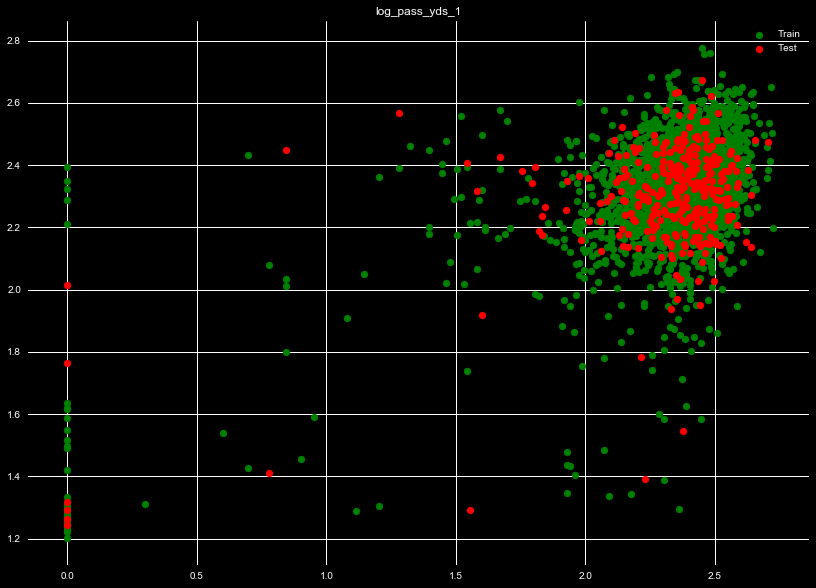

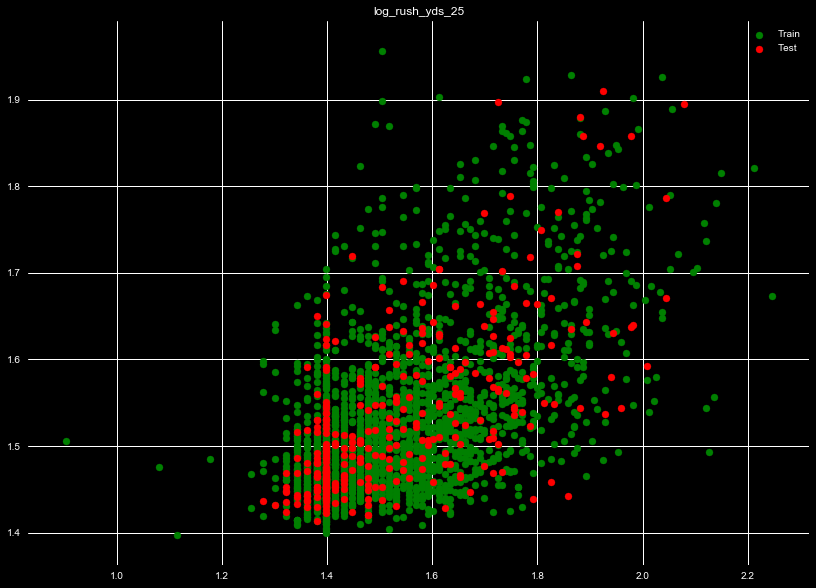

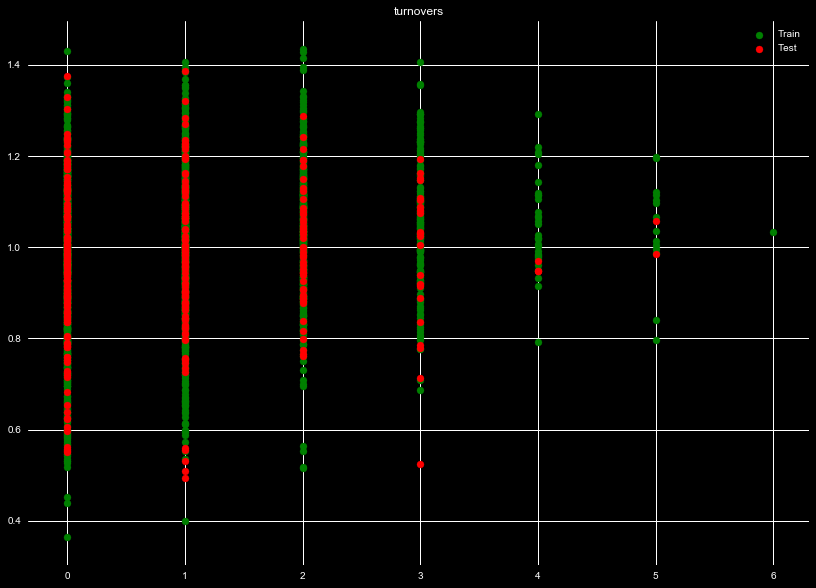

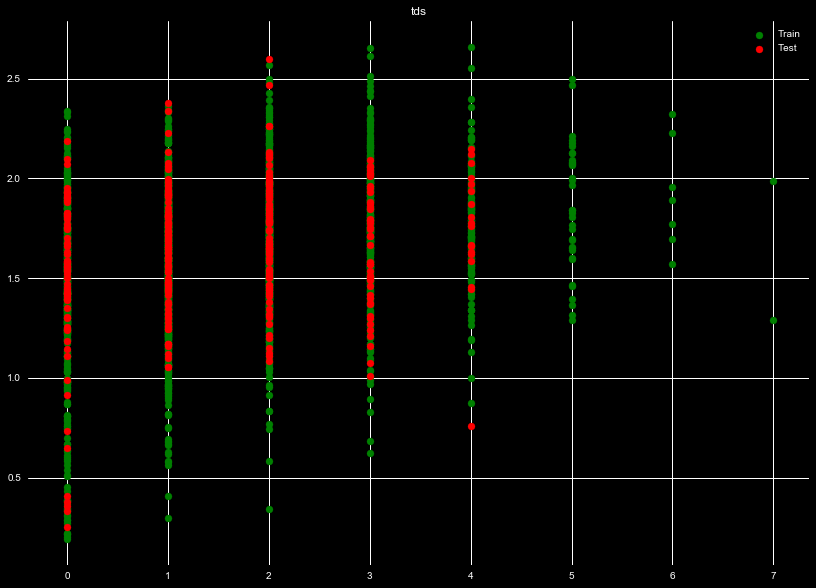

In [48]:
m_lin_reg = MultiOutputRegressor( LinearRegression() )

reg_test( m_lin_reg, train_x, train_y, test_x, test_y )

pred_test  = m_lin_reg.predict(  test_x )
pred_train = m_lin_reg.predict( train_x )

for i in range( 0, test_y.shape[1] ):
    plt.title( targets[i] )
    plt.scatter( train_y[:,i], pred_train[:,i], color='g', label='Train' )
    plt.scatter(  test_y[:,i], pred_test [:,i], color='r', label='Test'  )
    plt.legend()
    plt.show()

Train Data:
R^2
 log_pass_yds_1 0.000000
log_rush_yds_25 0.000000
      turnovers 0.000000
            tds 0.000000
RMSE
 log_pass_yds_1 0.346229
log_rush_yds_25 0.160297
      turnovers 1.041539
            tds 1.223139
RMSE / Mean
 log_pass_yds_1 0.227616
log_rush_yds_25 0.129777
      turnovers 1.037323
            tds 0.959272
Test Data:
R^2
 log_pass_yds_1 0.004976
log_rush_yds_25 0.006421
      turnovers 0.007923
            tds 0.005113
RMSE
 log_pass_yds_1 0.385049
log_rush_yds_25 0.170572
      turnovers 1.020314
            tds 1.122683
RMSE / Mean
 log_pass_yds_1 0.254632
log_rush_yds_25 0.137482
      turnovers 1.065093
            tds 0.903005


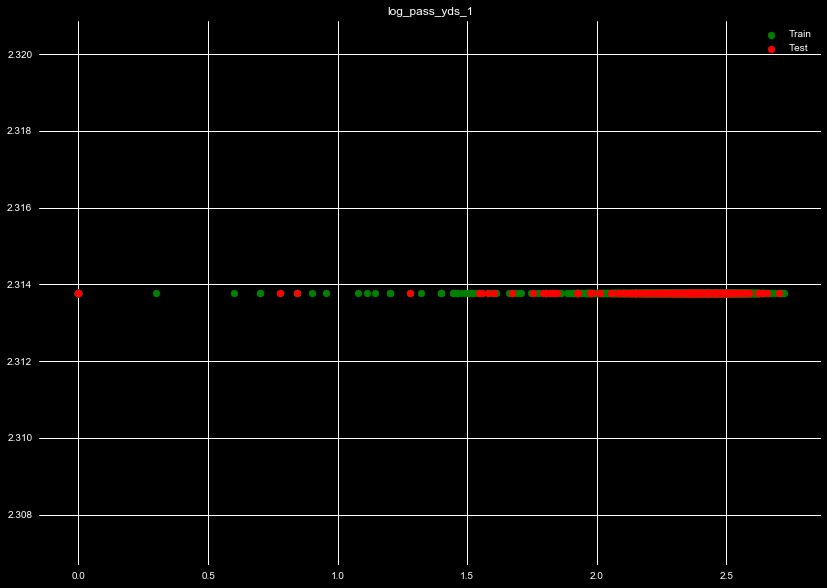

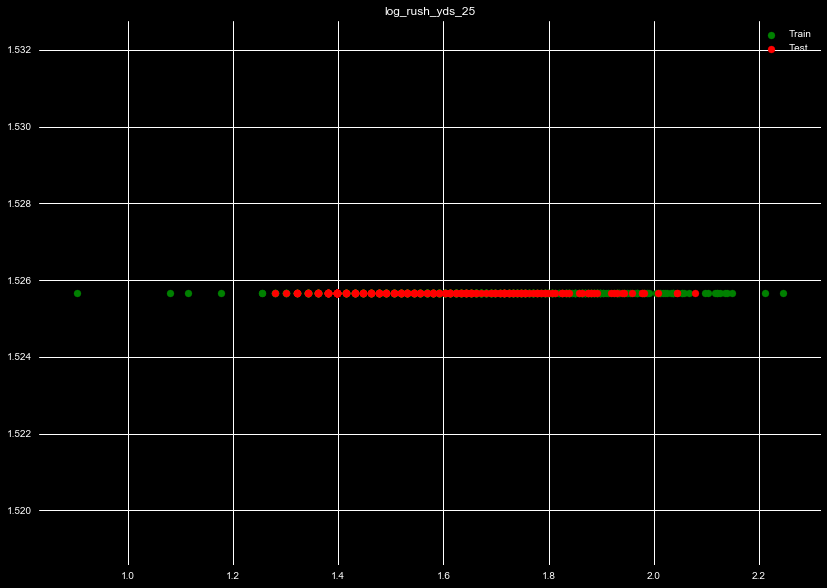

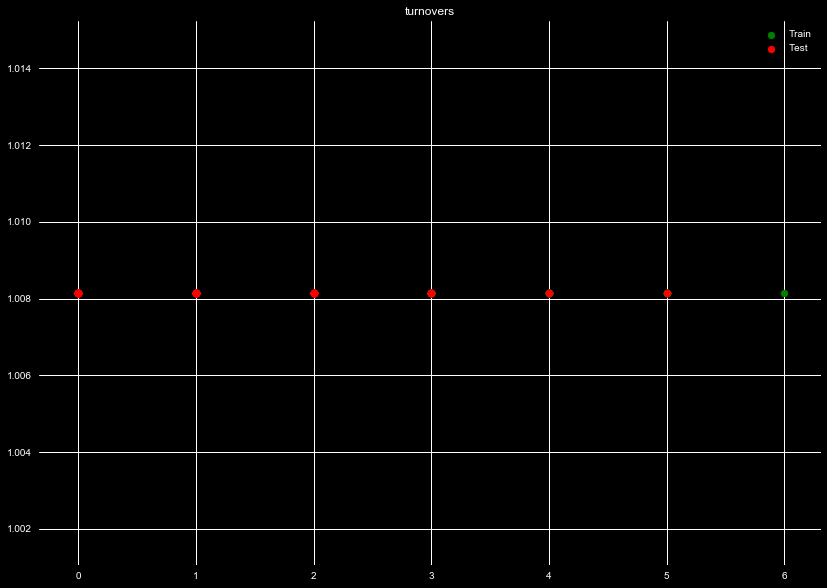

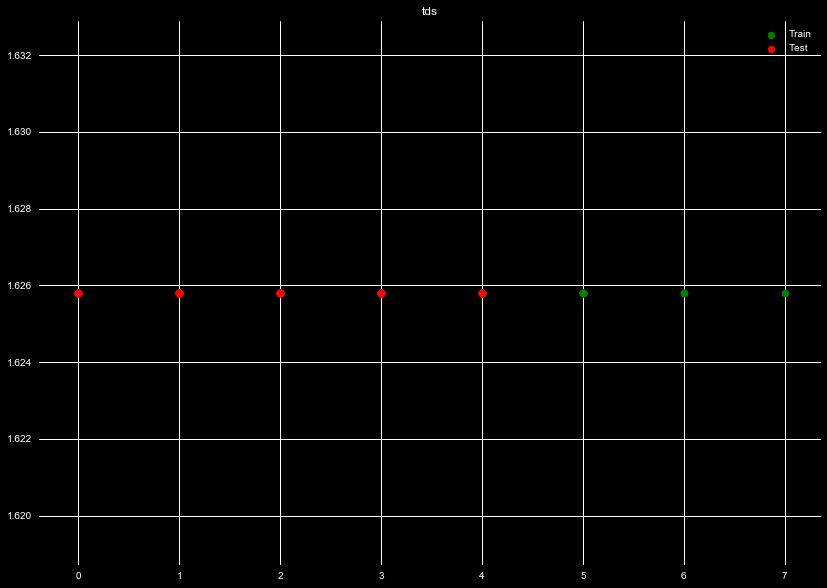

In [19]:
m_las_reg = MultiOutputRegressor( Lasso(alpha=0.5) )

reg_test( m_las_reg, train_x, train_y, test_x, test_y )

pred_test  = m_las_reg.predict(  test_x )
pred_train = m_las_reg.predict( train_x )

for i in range( 0, test_y.shape[1] ):
    plt.title( targets[i] )
    plt.scatter( train_y[:,i], pred_train[:,i], color='g', label='Train' )
    plt.scatter(  test_y[:,i], pred_test [:,i], color='r', label='Test'  )
    plt.legend()
    plt.show()

Train Data:
R^2
 log_pass_yds_1 0.571963
log_rush_yds_25 0.345768
      turnovers 0.215235
            tds 0.255131
RMSE
 log_pass_yds_1 0.230821
log_rush_yds_25 0.121506
      turnovers 0.915645
            tds 1.036480
RMSE / Mean
 log_pass_yds_1 0.151745
log_rush_yds_25 0.098372
      turnovers 0.911939
            tds 0.812881
Test Data:
R^2
 log_pass_yds_1 0.674322
log_rush_yds_25 0.274223
      turnovers 0.273957
            tds 0.304298
RMSE
 log_pass_yds_1 0.313421
log_rush_yds_25 0.168526
      turnovers 1.117216
            tds 1.240722
RMSE / Mean
 log_pass_yds_1 0.207265
log_rush_yds_25 0.135833
      turnovers 1.166247
            tds 0.997947


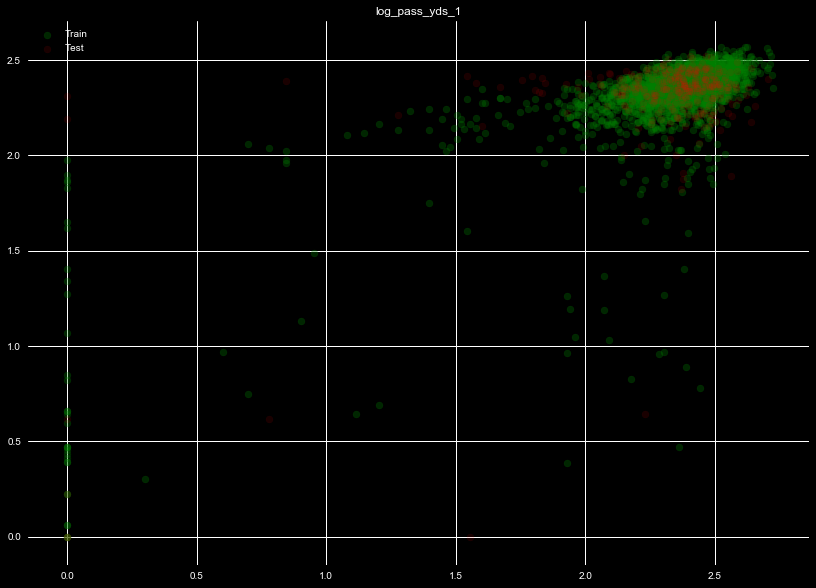

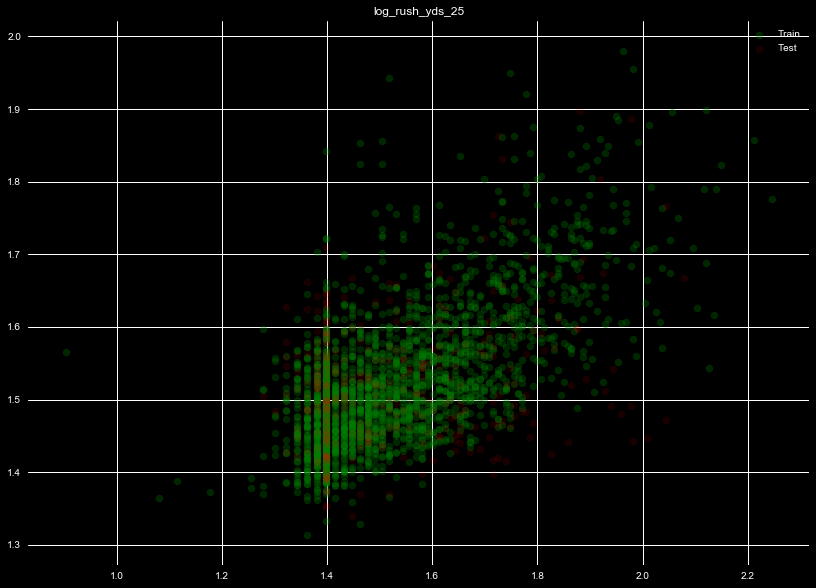

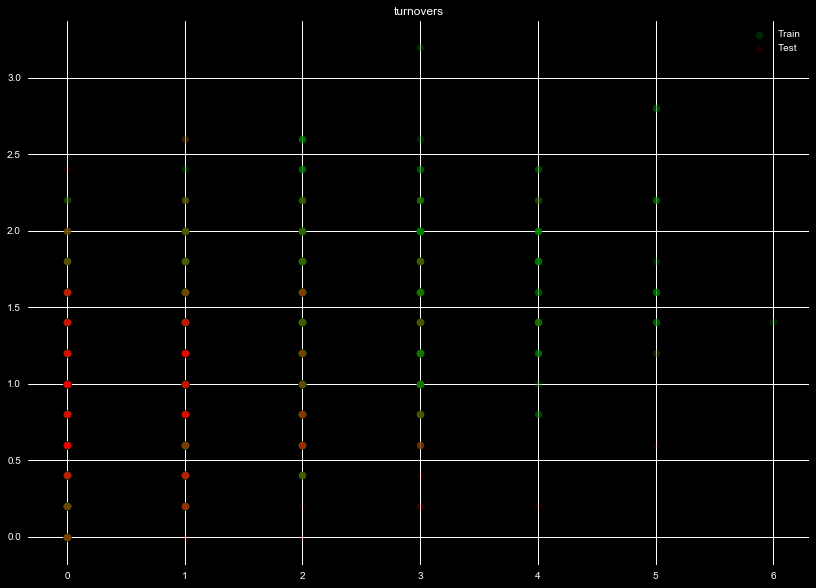

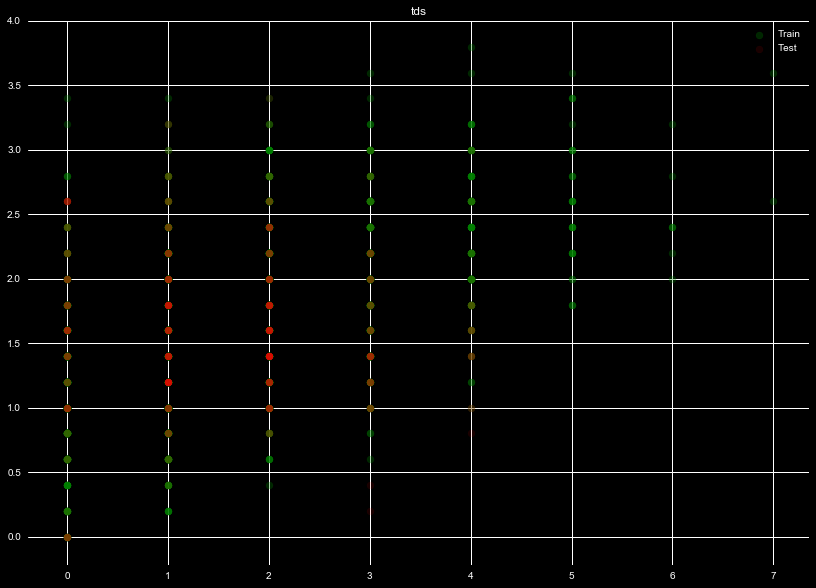

In [22]:
m_knn_reg = MultiOutputRegressor( KNeighborsRegressor(n_neighbors=5) )

reg_test( m_knn_reg, train_x, train_y, test_x, test_y )

pred_test  = m_knn_reg.predict(  test_x )
pred_train = m_knn_reg.predict( train_x )

for i in range( 0, test_y.shape[1] ):
    plt.title( targets[i] )
    plt.scatter( train_y[:,i], pred_train[:,i], color='g', label='Train', alpha=0.3 )
    plt.scatter(  test_y[:,i], pred_test [:,i], color='r', label='Test' , alpha=0.1 )
    plt.legend()
    plt.show()

Train Data:
R^2
 log_pass_yds_1 0.677022
log_rush_yds_25 0.647893
      turnovers 0.473443
            tds 0.501304
RMSE
 log_pass_yds_1 0.116258
log_rush_yds_25 0.057143
      turnovers 0.471707
            tds 0.535323
RMSE / Mean
 log_pass_yds_1 0.076430
log_rush_yds_25 0.046263
      turnovers 0.469798
            tds 0.419838
Test Data:
R^2
 log_pass_yds_1 0.585295
log_rush_yds_25 0.385554
      turnovers 0.173269
            tds 0.223314
RMSE
 log_pass_yds_1 0.296129
log_rush_yds_25 0.147136
      turnovers 1.048998
            tds 1.171511
RMSE / Mean
 log_pass_yds_1 0.195830
log_rush_yds_25 0.118593
      turnovers 1.095036
            tds 0.942279


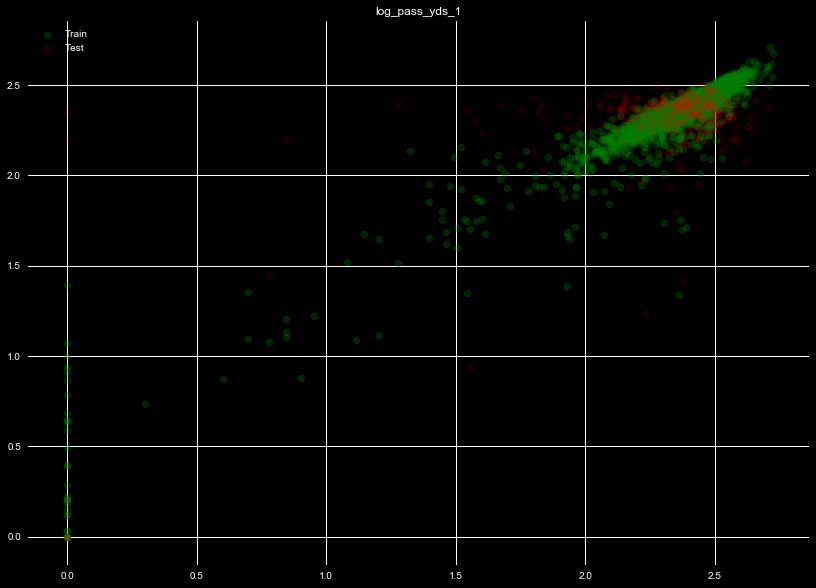

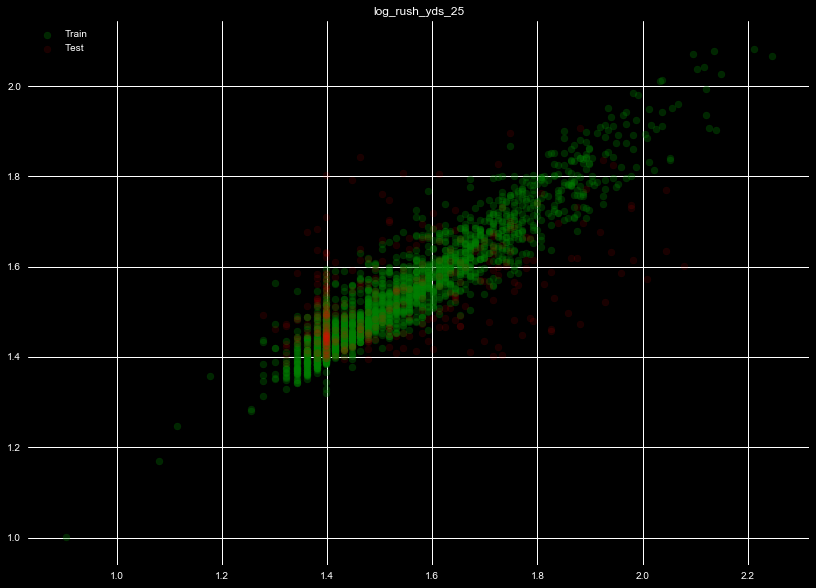

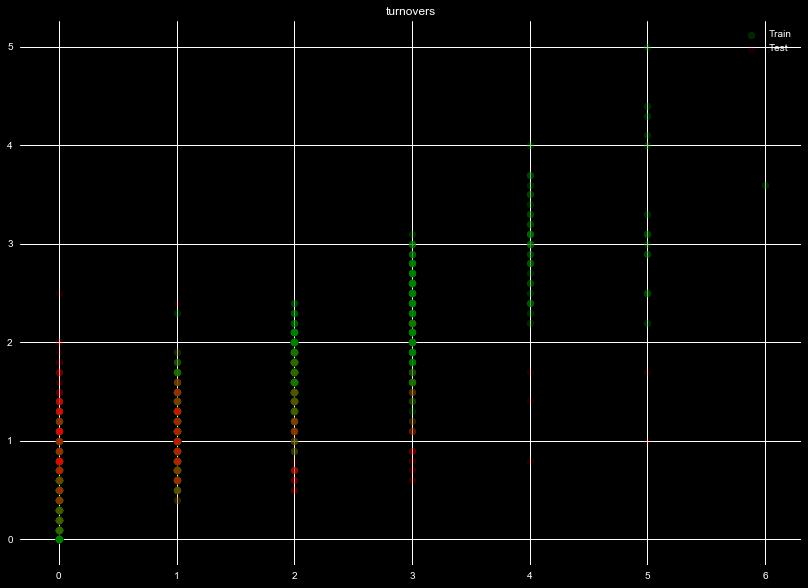

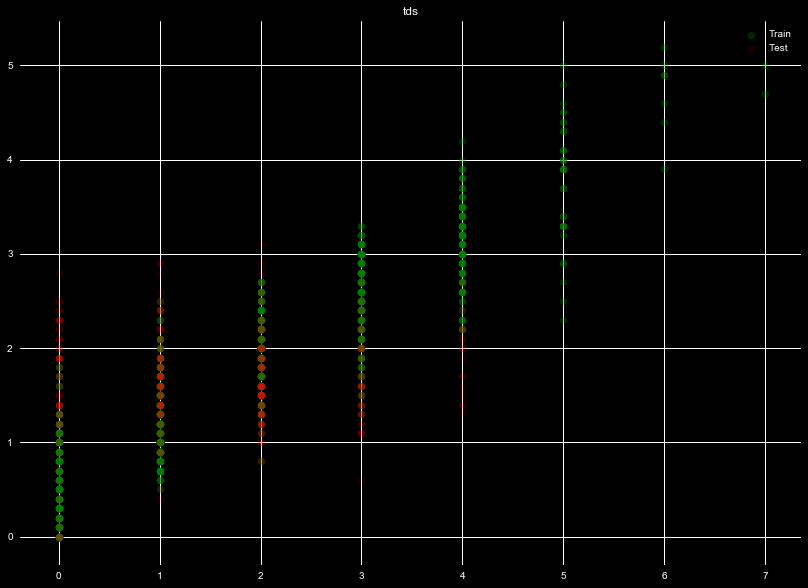

In [24]:
m_rfr_reg = MultiOutputRegressor( RandomForestRegressor() )

reg_test( m_rfr_reg, train_x, train_y, test_x, test_y )

pred_test  = m_rfr_reg.predict(  test_x )
pred_train = m_rfr_reg.predict( train_x )

for i in range( 0, test_y.shape[1] ):
    plt.title( targets[i] )
    plt.scatter( train_y[:,i], pred_train[:,i], color='g', label='Train', alpha=0.3 )
    plt.scatter(  test_y[:,i], pred_test [:,i], color='r', label='Test' , alpha=0.1 )
    plt.legend()
    plt.show()

Train Data:
R^2
 log_pass_yds_1 0.571296
log_rush_yds_25 0.574075
      turnovers 0.207285
            tds 0.213407
RMSE
 log_pass_yds_1 0.271680
log_rush_yds_25 0.143388
      turnovers 0.842285
            tds 0.988708
RMSE / Mean
 log_pass_yds_1 0.178607
log_rush_yds_25 0.116087
      turnovers 0.838876
            tds 0.775415
Test Data:
R^2
 log_pass_yds_1 1.209359
log_rush_yds_25 1.499326
      turnovers 0.249134
            tds 0.344103
RMSE
 log_pass_yds_1 0.438640
log_rush_yds_25 0.249207
      turnovers 1.089886
            tds 1.214311
RMSE / Mean
 log_pass_yds_1 0.290072
log_rush_yds_25 0.200863
      turnovers 1.137718
            tds 0.976704


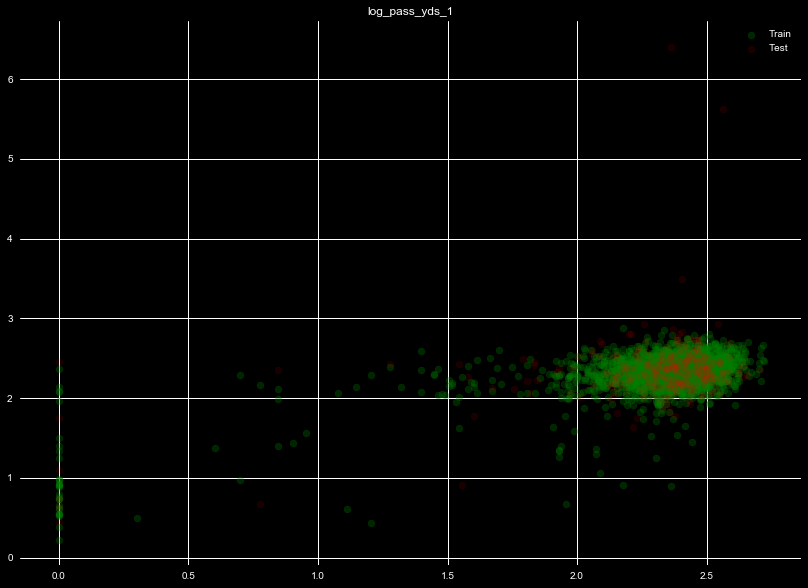

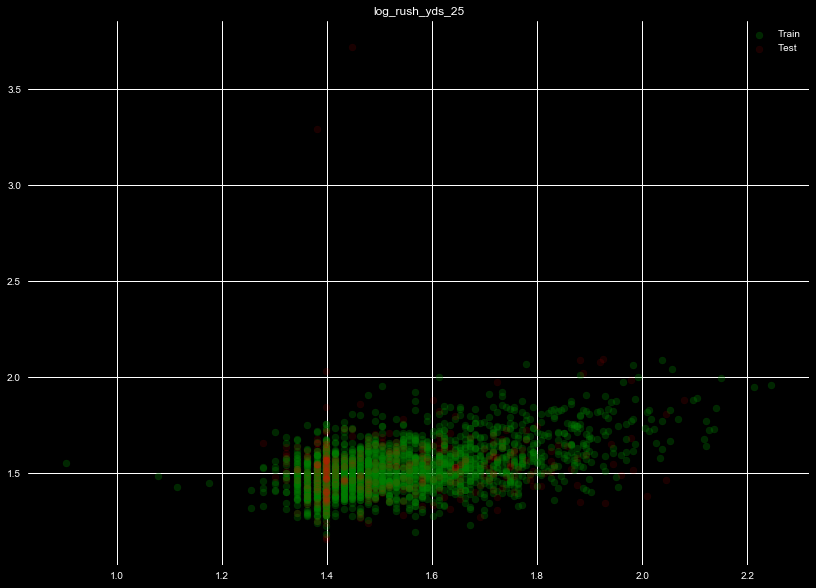

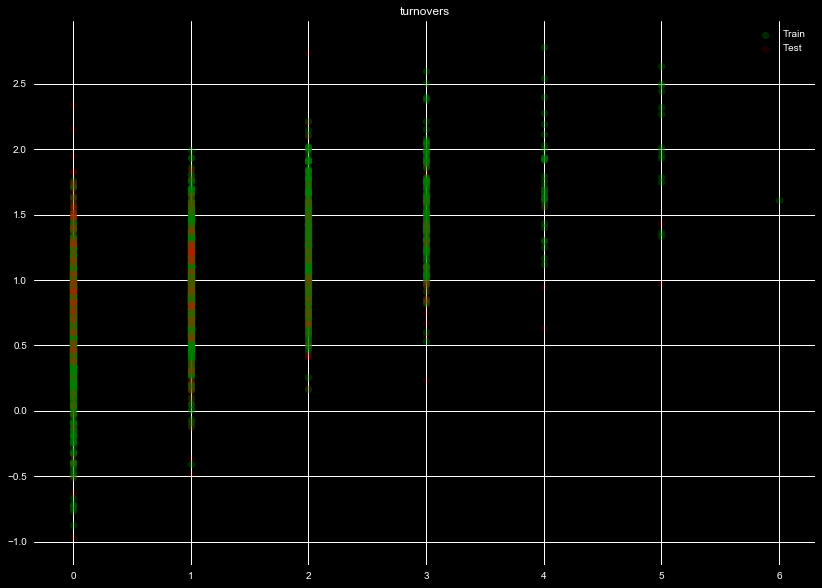

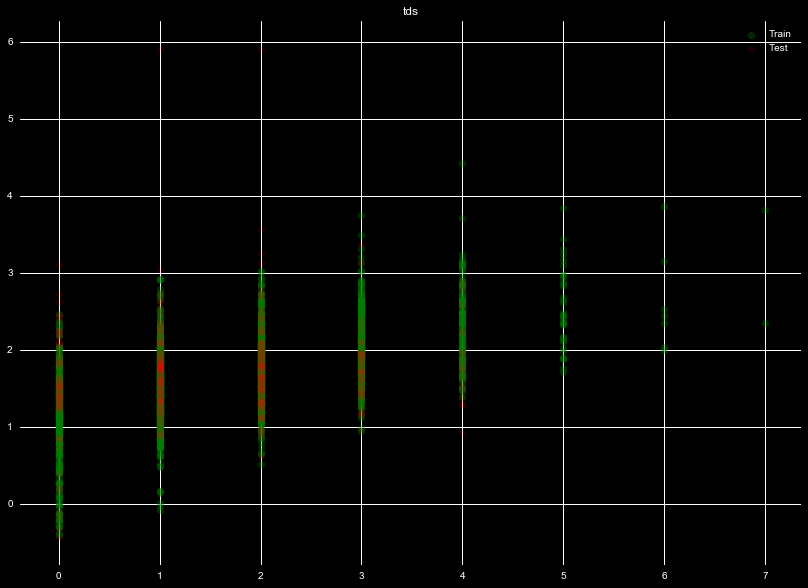

In [25]:
m_mlp_reg = MultiOutputRegressor( MLPRegressor() )

reg_test( m_mlp_reg, train_x, train_y, test_x, test_y )

pred_test  = m_mlp_reg.predict(  test_x )
pred_train = m_mlp_reg.predict( train_x )

for i in range( 0, test_y.shape[1] ):
    plt.title( targets[i] )
    plt.scatter( train_y[:,i], pred_train[:,i], color='g', label='Train', alpha=0.3 )
    plt.scatter(  test_y[:,i], pred_test [:,i], color='r', label='Test' , alpha=0.1 )
    plt.legend()
    plt.show()

Train Data:
R^2
 log_pass_yds_1 0.594889
log_rush_yds_25 0.389744
      turnovers 0.912328
            tds 0.796481
RMSE
 log_pass_yds_1 0.237149
log_rush_yds_25 0.118874
      turnovers 0.338700
            tds 0.450104
RMSE / Mean
 log_pass_yds_1 0.155905
log_rush_yds_25 0.096240
      turnovers 0.337330
            tds 0.353003
Test Data:
R^2
 log_pass_yds_1 0.653400
log_rush_yds_25 0.374224
      turnovers 1.253403
            tds 1.751625
RMSE
 log_pass_yds_1 0.317720
log_rush_yds_25 0.151680
      turnovers 1.503754
            tds 1.756554
RMSE / Mean
 log_pass_yds_1 0.210108
log_rush_yds_25 0.122256
      turnovers 1.569750
            tds 1.412845


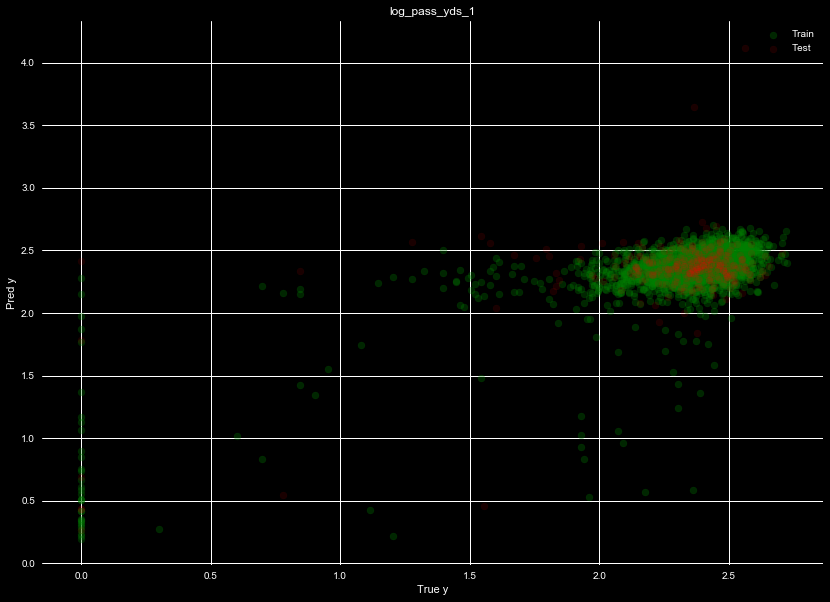

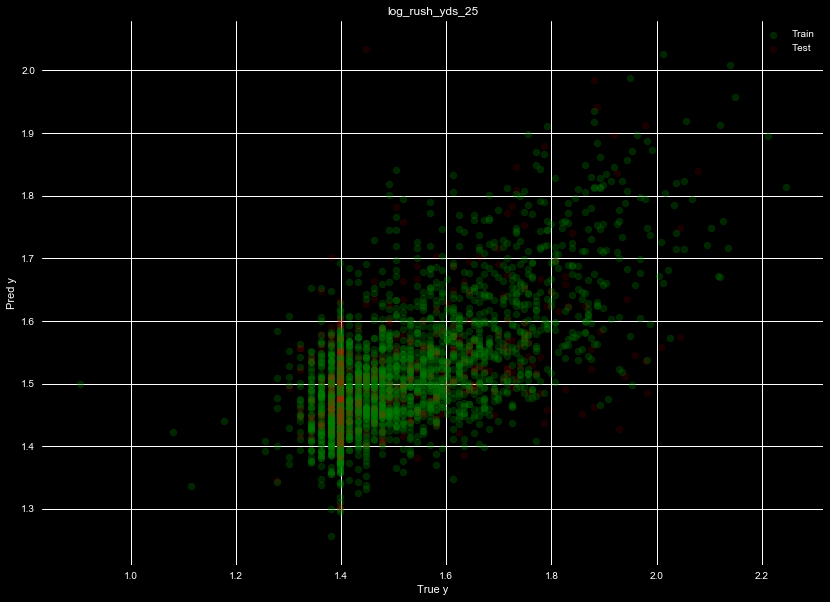

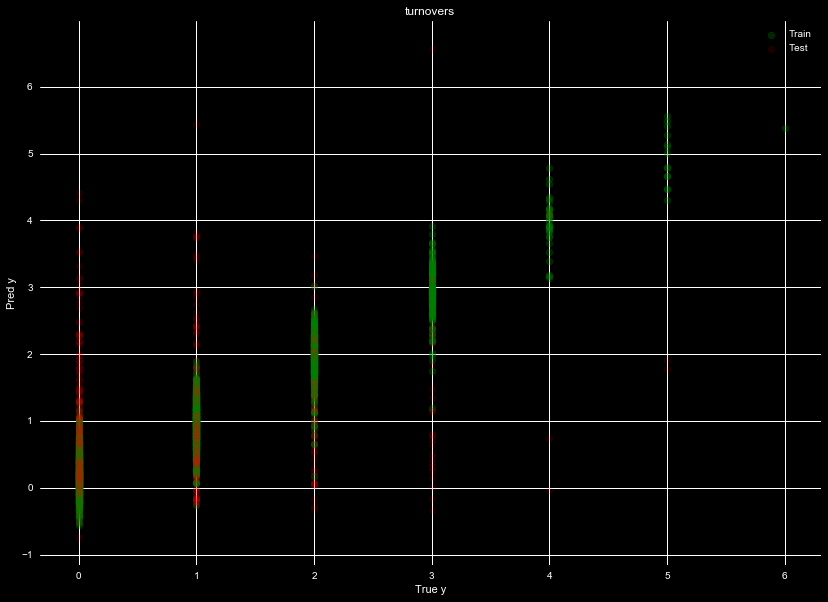

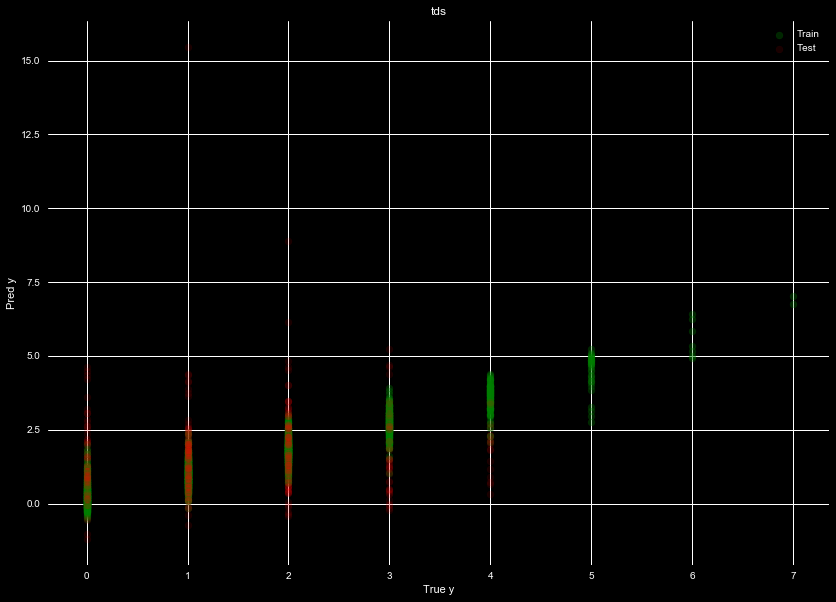

In [26]:
m_mlp_reg = MultiOutputRegressor( MLPRegressor( hidden_layer_sizes=(50,50,50,50,50,)) )

reg_test( m_mlp_reg, train_x, train_y, test_x, test_y )

pred_test  = m_mlp_reg.predict(  test_x )
pred_train = m_mlp_reg.predict( train_x )

for i in range( 0, test_y.shape[1] ):
    plt.title( targets[i] )
    plt.scatter( train_y[:,i], pred_train[:,i], color='g', label='Train', alpha=0.3 )
    plt.scatter(  test_y[:,i], pred_test [:,i], color='r', label='Test' , alpha=0.1 )
    plt.xlabel( 'True y' )
    plt.ylabel( 'Pred y' )
    plt.legend()
    plt.show()

Linear regressor does ok

Lasso fails completely

Knn MIGHT be able to predict whether there are multiple turnovers, if turned into classification

RFR DEFINITELY a contender

MLP DEFINITELY a contender

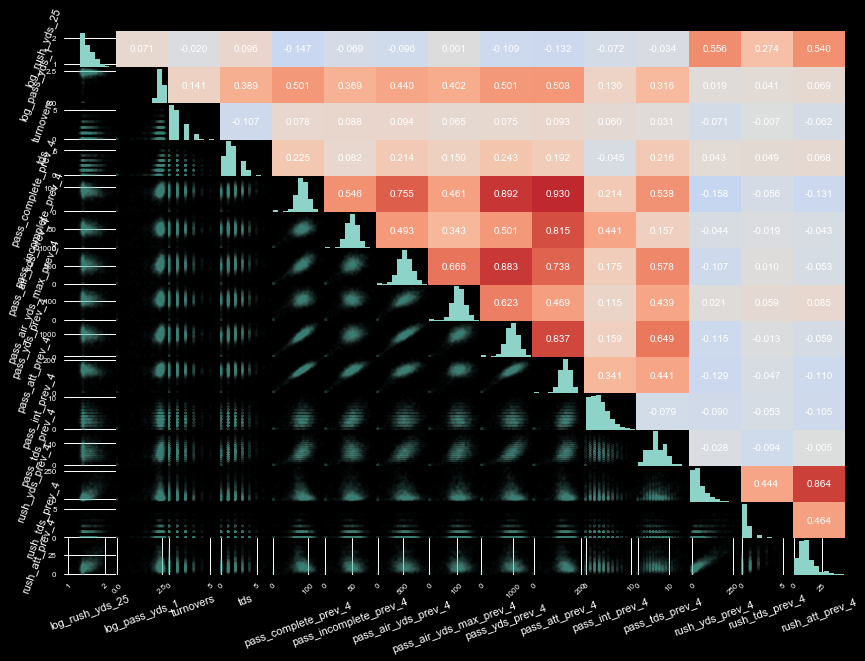

In [54]:
import df_visualizations as dv
reload(dv)

dv.corr_plot( temp_df[target_variables+player_scales+player_norms], alpha=0.01)

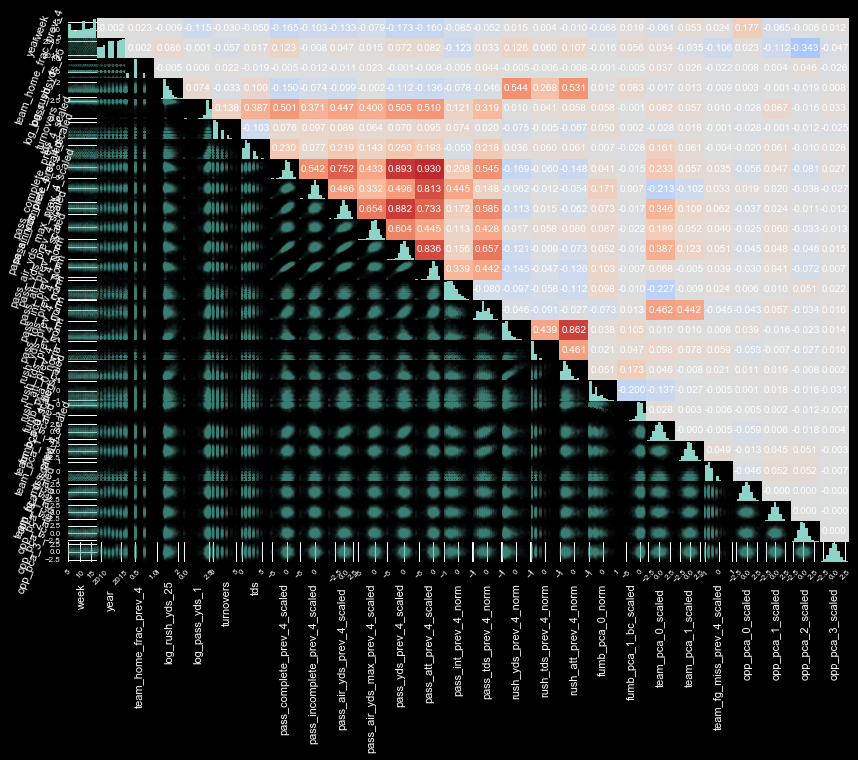

In [55]:
dv.corr_plot( train_norm_data, x_label_rotation=90, alpha=0.01)